- A model outputs logits.
- In multi-class segmentation tasks, usually the models outputs a tensor with shape [C, H, W], where C is the number of classes (background included) and where each channel is a sort of binary segmentation for the objects of that class. Every "pixel" has a higher logit in the channel of the class it probably belongs, and a lower logits in all the other channels, for it is less likely the "pixel" belongs to those classes. (This is a bit redundant in binary segmentation tasks because there are only two classes, background and object).
- There are logits also in the channel for the background class.
- To be confronted with the GT, which can be seen as a one-hot encoded probability distribution along the classes for each pixel, these logits are turned into a probability distribution, AKA into probs between 0 and 1. The Sigmoid is used in binary segmentation cases, while the Softmax in used in multi-class segmentation cases.
- No threshold is applied before computing the loss (whatever loss it is). The threshold is applied when we want to see the prediction, so we turn the logits into probs again, apply the threshold, thus turning the pred to boolean and then plot it.
- Binary Cross-Entropy is just a sub-type of Cross-Entropy: there are just two classes.
- Both CE anb BCE need the predictions to be as probabilities, that is the sum over the classes must be 1. In reality many implementation take logits but that's because a Softmax (for CE) or a Sigmoid (for BCE) is applied internally.
- For cross-entropy loss, the position of the pixels doesn't matter: it's as if a flattening in performed on the image turning it into a vector.
- Interesting source: https://gombru.github.io/2018/05/23/cross_entropy_loss/

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# <ins> CROSS-ENTROPY LOSS FOR SEGMENTATION

## FUNCTION

In [2]:
def cross_entropy_loss(pred, true):
    """
    Compute Cross-Entropy loss on predicted logits for a single example for an image segmentation task.
      
    Pred can either:
    1) consist of as many channels as number of classes, thus having shape (C, H, W), being
    C the number of classes (including background). In this case the function computes standard 
    cross-entropy loss and a softmax activation function is applied across classes.
    2) have shape (H, W), thus being a case of binary segmentation. In this case the function
    computes binary cross-entropy, thus needing a sigmoid activation function, which is applied.
    
    Args:
        pred (torch.tensor): model prediction as logits. 
        true (torch.tensor): target with shape (H, W), each pixel having an integer ID
            label indicating the class it belongs to.
        
    Returns:
        Cross-Entropy loss value.
    """

    n_classes = len(torch.unique(true)) # background is counted as a class
    height = pred.shape[-2]
    width = pred.shape[-1]

    # If there are only two classes, it's a binary segmentatio problem,
    # so the sigmoid should be used as activation function to turn logits into probs.
    if n_classes == 2:
        activation_function = torch.nn.Sigmoid()
        # Add channel dimension also to pred
        pred = pred.unsqueeze(0) # shape = [C, H, W] = [1, H, W]
       
    # If there are more than two classes, it's a multi-class segmentation problem,
    # so the softmax should be used as activation function to turn logits into probs.
    elif n_classes > 2:
        activation_function = torch.nn.Softmax(dim=0)
    
    # Convert to required type
    pred = pred.type(torch.float32)
    true = true.type(torch.int64)
    
    # Turn GT mask to one-hot-encoding,
    # with as many channels as number of classes, 
    # where every channel is a sort of a binary segmentation mask with
    # the objects of that class.
    true_ohe = torch.nn.functional.one_hot(true, num_classes=n_classes).permute(2, 0, 1) # shape = [C, H, W]
      
    # Basically in the computation of the CE loss for image segmentation,
    # each pixel of the prediction is a probability distribution along the
    # channels, that is along the classes. This vector is compared to the target
    # prob distribution (one-hot encoded) by calculating the CE loss with the
    # standard formula. The CE losses of all the pixels are then averaged to
    # get the final CE loss for that image.
    
    # # # MULTICLASS SEGMENTATION
    if n_classes > 2: 
        pixel_losses = []
        for i in range(height):
            for j in range(width):
                # Get logits of the pixel along the channels/classes.
                pixel_i_pred_logits = pred[..., i, j] # shape = [n_classes]
                # Use softmax to turn the logits into a probability distribution along the classes.
                pixel_i_pred_probs = activation_function(pixel_i_pred_logits) # shape = [n_classes]
                # Remove zeros otherwise later matrix multiplication error.
                pixel_i_pred_probs = torch.where(pixel_i_pred_probs == 0., 1e-8, pixel_i_pred_probs)
                # Get GT probability distribution.
                pixel_i_true_probs = true_ohe[..., i, j].type(torch.float32) # shape = [n_classes]
                # Turn both pred and true to matrix with shape (1, n_classes), 
                # to perform the matrix multiplication.
                pixel_i_pred_probs = pixel_i_pred_probs.unsqueeze(0) # shape = [1, n_classes]
                pixel_i_true_probs = pixel_i_true_probs.unsqueeze(0) # shape = [1, n_classes]
                # Compute Cross-Entropy loss for the single pixel.
                pixel_i_loss = -torch.matmul(
                    torch.log(pixel_i_pred_probs),
                    pixel_i_true_probs.T # transpose to change shape to [n_classes, 1]
                )
                pixel_losses.append(pixel_i_loss.item())
                
    # # # BINARY SEGMENTATION
    if n_classes == 2:
        pixel_losses = []
        for i in range(height):
            for j in range(width):
                # Get logit of the pixel
                pixel_i_pred_logit = pred[..., i, j] # shape = [1]
                # Use sigmoid to turn the logit into a prob.
                pixel_i_pred_prob = activation_function(pixel_i_pred_logit) # shape = [1]
                # Transform in a tensor with the prob of belonging to background and
                # prob of belonging to an object.
                pixel_i_pred_probs = torch.cat((1. - pixel_i_pred_prob, pixel_i_pred_prob)) # shape = [2]
                # Remove zeros otherwise later matrix multiplication error.
                pixel_i_pred_probs = torch.where(pixel_i_pred_probs == 0., 1e-8, pixel_i_pred_probs)
                # Get GT probability distribution.
                pixel_i_true_probs = true_ohe[..., i, j].type(torch.float32) # shape = [2]
                # Turn both pred and true to matrix with shape (1, n_classes), 
                # to perform the matrix multiplication.
                pixel_i_pred_probs = pixel_i_pred_probs.unsqueeze(0) # shape = [1, 2]
                pixel_i_true_probs = pixel_i_true_probs.unsqueeze(0) # shape = [1, 2]
                # Compute Cross-Entropy loss for the single pixel.
                pixel_i_loss = -torch.matmul(
                    torch.log(pixel_i_pred_probs), 
                    pixel_i_true_probs.T # transpose to change shape to [2, 1]
                )
                pixel_losses.append(pixel_i_loss.item())
        
    # The CE loss for the image is the average of the CE losses of all its pixels.
    loss = np.round(np.mean(pixel_losses), 3).item()
    
    return loss

## FOR BINARY SEGMENTATION

In [3]:
# GT
true = torch.tensor([
    [0, 1, 1, 1, 0],
    [0, 1, 0, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1]
])

# Prediction by a model (logits)
pred = torch.tensor([
    [-0.9833, -0.7652, -0.7690,  1.5309, -2.4188],
    [ 0.8150, -1.1432,  1.3916, -0.1599, -0.9577],
    [ 0.8008, -0.6601, -0.6325, -0.3961,  1.4413],
    [ 0.5683,  1.3544, -0.2154,  0.5649,  1.3917],
    [-0.5142, -2.0285, -2.2410, -0.6006, -0.1540]
])

true.shape, pred.shape

(torch.Size([5, 5]), torch.Size([5, 5]))

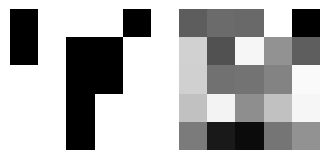

In [4]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
axis[0].imshow(true, cmap='gray')
axis[0].axis('off')
axis[1].imshow(pred, cmap='gray')
axis[1].axis('off')
plt.show()

In [5]:
# Binary cross-entropy by PyTorch
bce_loss_pytorch = torch.nn.BCEWithLogitsLoss()
bce_loss_pytorch(input=pred, target=true.float()).numpy().round(3)

0.744

In [6]:
# Binary cross-entropy by my function
bce = cross_entropy_loss(pred=pred, true=true)
bce

0.744

## FOR MULTI-CLASS SEGMENTATION

In [7]:
# GT, with 4 classes (background included)
true = torch.tensor([
    [0, 1, 1, 1, 0],
    [0, 1, 0, 0, 3],
    [2, 2, 0, 0, 3],
    [2, 2, 0, 3, 3],
    [2, 2, 0, 3, 3]
])

# Pred
torch.manual_seed(42)
pred = torch.randn(size=(4, 5, 5))

true.shape, pred.shape

(torch.Size([5, 5]), torch.Size([4, 5, 5]))

In [8]:
# Cross-entropy by PyTorch

# By Piotr Bialecki:
# Expects the model output to have shape [batch_size, nb_classes, height, width] and
# the target [batch_size, height, width], containing the class indices in the 
# range [0, nb_classes-1].

ce_loss_pytorch = torch.nn.CrossEntropyLoss()
ce_loss_pytorch (pred[None, ...], true[None, ...]).numpy().round(3)

1.386

In [9]:
# Cross-entropy by my function
ce = cross_entropy_loss(pred=pred, true=true)
ce

1.386

In [13]:
# Simulating a very good prediction by a model: loss should be close to 0.
x = 2. # higher --> the more perfect the prediction is.

pred = torch.cat([
    torch.where(true == 0., x, -x)[None, ...],
    torch.where(true == 1., x, -x)[None, ...],
    torch.where(true == 2., x, -x)[None, ...],
    torch.where(true == 3., x, -x)[None, ...],
])

print(ce_loss_pytorch(pred[None, ...], true[None, ...]).numpy().round(3))
print(cross_entropy_loss(pred, true))

0.053
0.053


## OPTIMIZED AND WEIGHTED VERSION

In [30]:
from typing import List, Optional

class WeightedCrossEntropyLoss(torch.nn.Module):
    '''A PyTorch Module for computing weighted cross entropy loss.
    
    Args:
        class_weights: A tensor with class weights.    
    '''
    def __init__(self, class_weights: Optional[torch.Tensor]=None) -> None:
        super().__init__()
        self.activation = torch.nn.Softmax(dim=1)
        self.class_weights = class_weights

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        '''Computes the weighted cross-entropy loss between the input and target.
    
        Args:
            input: A tensor with model logits. Required shape [batch size, n classes, H, W]. 
            target: A tensor with GT one-hot-encoded. Required shape [batch size, n classes, H, W].
                
        Returns:
            torch.Tensor: A scalar tensor representing the computed weighted cross-entropy loss for the input batch,
            as average on all pixel losses.
        
        '''
        input_activated = self.activation(input)
        input_activated = torch.where(input_activated == 0., torch.tensor(1e-8), input_activated)
        pixel_losses = -torch.sum(target * torch.log(input_activated), dim=1) # shape = [H, W]

        if self.class_weights is not None:
            weighted_pixel_losses = target * self.class_weights.view(1, -1, 1, 1) # basically the target tensor with class weights instead of ones.
            weighted_pixel_losses = torch.sum(weighted_pixel_losses, dim=1) # basically the mask [H, W] with class indexes but with the weights.
            pixel_losses = pixel_losses * weighted_pixel_losses # weight every pixel loss.
        
        batch_loss = torch.mean(pixel_losses) # batch loss as average over all pixel losses
        
        return batch_loss

In [27]:
true_ohe = torch.nn.functional.one_hot(true, num_classes=4).permute(2, 0, 1) # shape = [C, H, W]

In [28]:
ce_loss = WeightedCrossEntropyLoss()
ce_loss(pred[None, ...], true_ohe[None, ...]).numpy().round(3)

0.053

In [32]:
ce_loss = WeightedCrossEntropyLoss(class_weights=torch.tensor([0.0, 0.5, 0.3, 0.2]).to(pred.device))
ce_loss(pred[None, ...], true_ohe[None, ...]).numpy().round(3)

0.011

- The preferred format for the weights is with range [0, 1].
- If we use fraction weights [0, 1] (as above) or integer weights [0, +inf] with equivalent proportions, the results will not be the same, contrary to what one may expect. This is because of how the weights are multiplied to the CE formula.
- In a nutshell, when weights are integers, we are multiplying the loss of the different classes by different coeffiecients. When the weights are fractions, we are reducing the loss of each class by different percentages: some classes are reduce more, other less.
- Only numbers change, while the reciprocal relation between classes is the same for integers or fraction weights.
- Remember: the value of the loss means nothing, it is the difference between consecutive losses to matter.

# <ins> CROSS-ENTROPY LOSS FOR CLASSIFICATION

## FOR MULTI-CLASS CLASSIFICATION

In [11]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
torch.manual_seed(543)
loss_fn = torch.nn.CrossEntropyLoss()
preds = torch.randn(size=(3, 5), dtype=torch.float32) # 3 is number of data examples, 5 is the number of classes.
targets = torch.empty(3, dtype=torch.long).random_(5) # long type required by one-hot-encoding.

In [13]:
print(preds.shape, targets.shape)
print(preds.dtype, targets.dtype)

torch.Size([3, 5]) torch.Size([3])
torch.float32 torch.int64


In [14]:
# Predictions as logits.
preds

# Each row is a single example and the columns are the logits
# for each one of the classes.

tensor([[-1.9000,  1.0630,  0.1354, -0.3442,  1.4945],
        [-1.9455, -2.0836,  0.8109, -0.3634,  0.4801],
        [ 0.7173,  0.4489, -1.6775, -0.7023,  0.3009]])

In [15]:
# GTs as class ID each example belongs to.
targets

tensor([0, 2, 3])

In [16]:
# GTs one-hot-encoded.
targets_ohe = torch.nn.functional.one_hot(targets, num_classes=5).type(torch.float32)
targets_ohe

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]])

In [17]:
# Cross-entropy loss by PyTorch for the batch of data.
crossent = torch.nn.CrossEntropyLoss()
print(crossent(preds, targets))
print(crossent(preds, targets_ohe))

tensor(2.4445)
tensor(2.4445)


In [18]:
# Basically the loss is computed for each example separately, then averaged.
losses = []
for i in range(len(preds)):
    loss = crossent(preds[i], targets[i])
    losses.append(loss.item())

np.mean(losses).round(4)

2.4445

In [19]:
# Cross-entropy loss from scratch.
n_data = len(targets)
single_losses = []

for i in range(n_data):
    # Take gt and prediction of single example.
    true = targets_ohe[i]
    pred = preds[i]
    # Turn to matrix with shape (1, 5), to be able to
    # do the matrix multiplication.
    true = true.unsqueeze(0)
    pred = pred.unsqueeze(0)
    # Turn pred logits to range [0, 1] with softmax.
    pred_soft = torch.softmax(pred, dim=1)
    # Compute cross entropy loss for single example.
    loss = -torch.matmul(
        torch.log(pred_soft), # shape (1, 5)
        true.T # transpose to change shape to (5, 1)
    )
    single_losses.append(loss.item())

single_losses = torch.tensor(single_losses)
print(single_losses)

tensor([4.1360, 0.7637, 2.4338])


In [20]:
# The final loss, that is the loss for the batch, is the mean of the single losses.
batch_loss = single_losses.mean().numpy().round(4)
batch_loss

2.4445

## FOR BINARY CLASSIFICATION

- When there are just two classes: 0 and 1.
- In binary classification problems, the activation function is the Sigmoid function: a function that converts any real-valued scalar to a point in the interval [0, 1].
- In binary classification problems we have two classes: Class-A and Not-Class-A --> 1 for Class-A and 0 for Not-Class-A.
- The model, for a given example, returns a logit for its belonging to Class-A. The Sigmoid function turns the logit into a [0, 1] value, that can be seen as the probability to belong to Class-A (p). Consequently, the probability to belong to Not-Class-A is 1-p.
- The Softmax for binary classification problem cannot be used because it requires a vector of values. In binary classification problems, for a single example, with have just 1 value (the logit), while in multi-class classification problems, for a single example, we have multiple values (logits), that is a vector of values, one for each one of the classes. For this reason it makes sense to use the Softmax for multi-class classification problems.
- Quote from Wiki: _"The softmax function converts a vector of K real numbers into a probability distribution of K possible outcomes."_.
- The Softmax can be seen as an extension of the Sigmoid, or in another perspective it can be demonstrated that the Sigmoid is a special case of the Softmax, where there are just two classes.

In [21]:
sigmoid = torch.nn.Sigmoid()
bce = torch.nn.BCELoss()

In [22]:
# Random generation with seed
torch.manual_seed(1888)
n_examples = 7
preds = torch.randn(n_examples)
targets = torch.empty(n_examples).random_(2)

In [23]:
# Logits, AKA scores for class belonging (more understandable as probabilities...)
preds

tensor([-1.5843, -0.0216, -1.1199, -0.6197,  0.2238, -0.3295, -1.5031])

In [24]:
# Pred as probabilities
# for each example, it's the probability to belong to class 1
# Since for binary classification problems the chosen activation function is the Sigmoid,
# the sum doesn't add to 1, and that's correct because every value belong to a different
# example and their sum being 1 makes no sense (it makes sense in multi-class classification
# problems where the probs of each class for a single example should add up to 1).
preds_probs = sigmoid(preds)
preds_probs = torch.round(preds_probs, decimals=2)
preds_probs

tensor([0.1700, 0.4900, 0.2500, 0.3500, 0.5600, 0.4200, 0.1800])

In [25]:
# Targets, that is true class for each example.
targets

tensor([1., 1., 0., 0., 1., 0., 1.])

In [26]:
# Binary Cross-Entropy
loss = bce(preds_probs, targets)
loss

tensor(0.8633)

In [27]:
# If the preds were closer to the targets, loss would have been lower.
# (Ignore the fact that those preds are clearly not coming from a softmax...)
bce(
    input = torch.tensor([0.8, 0.9, 0.2, 0.1, 0.7, 0.3, 0.9]),
    target = targets
)

tensor(0.2108)

How to compute it...

In [28]:
# One-hot encode targets.
# If target_i has class "0" it means that is 1 for class "0" and 0 for class "1".
targets_ohe = torch.nn.functional.one_hot(targets.long(), num_classes=2).type(torch.float32)

print(targets)
print()
print(targets_ohe)

tensor([1., 1., 0., 0., 1., 0., 1.])

tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])


In [29]:
### Turn preds into matrix

# Original preds: probability to belong to class 1
class_1_probs = preds_probs.clone()
print(class_1_probs)
print()

# Probability to belong to class 0
class_0_probs = torch.ones(size=class_1_probs.shape)
class_0_probs = class_0_probs - preds_probs
print(class_0_probs)
print()

# Build matrix 
preds_matrix = torch.stack([class_0_probs, class_1_probs], dim=1)
print(preds_matrix)
print()

# Still 7 examples and 2 classes
print(preds_matrix.shape)

tensor([0.1700, 0.4900, 0.2500, 0.3500, 0.5600, 0.4200, 0.1800])

tensor([0.8300, 0.5100, 0.7500, 0.6500, 0.4400, 0.5800, 0.8200])

tensor([[0.8300, 0.1700],
        [0.5100, 0.4900],
        [0.7500, 0.2500],
        [0.6500, 0.3500],
        [0.4400, 0.5600],
        [0.5800, 0.4200],
        [0.8200, 0.1800]])

torch.Size([7, 2])


In [30]:
# BCE from scratch, which is the same as the Cross-Entropy from scrath above.
n_data = len(preds_matrix)
single_losses = []

for i in range(n_data):
    # Take gt and prediction of single example.
    true = targets_ohe[i]
    pred = preds_matrix[i]
    # Turn to matrix with shape (1, 2), to be able to
    # do the matrix multiplication.
    true = true.unsqueeze(0)
    pred = pred.unsqueeze(0)
    # Turn pred logits to range [0, 1] with softmax.
    # pred_soft = torch.softmax(pred, dim=1)
    # Compute cross entropy loss for single example.
    loss = -torch.matmul(
        torch.log(pred), # shape (1, 5)
        true.T # transpose to change shape to (5, 1)
    )
    single_losses.append(loss.item())

single_losses = torch.tensor(single_losses)
batch_loss = single_losses.mean().numpy().round(4)
batch_loss    

0.8633

FOR CLASSIFICATION: Here is how to decide whether to apply sigmoid or softmax to the raw output values from your network:

-   If you have a multi-label classification problem = there is more than one "right answer" = the outputs are NOT mutually exclusive, then use a sigmoid function on each raw output independently. The sigmoid will allow you to have high probability for all of your classes, some of them, or none of them. Example: classifying diseases in a chest x-ray image. The image might contain pneumonia, emphysema, and/or cancer, or none of those findings.

-   If you have a multi-class classification problem = there is only one "right answer" = the outputs are mutually exclusive, then use a softmax function. The softmax will enforce that the sum of the probabilities of your output classes are equal to one, so in order to increase the probability of a particular class, your model must correspondingly decrease the probability of at least one of the other classes. Example: classifying images from the MNIST data set of handwritten digits. A single picture of a digit has only one true identity - the picture cannot be a 7 and an 8 at the same time.

# <ins> SOFTMAX VS SIGMOID

In [31]:
tensor = torch.tensor([-2.54, 4.1])

In [32]:
sigmoid = torch.nn.Sigmoid()
sigmoid(tensor)

tensor([0.0731, 0.9837])

In [33]:
softmax = torch.nn.Softmax(dim=0)
softmax(tensor)

tensor([0.0013, 0.9987])

In [34]:
sigmoid(torch.tensor([-2.54]))

tensor([0.0731])

In [35]:
softmax(torch.tensor([-2.54]))

tensor([1.])

The sigmoid works indipendentely on each value, while the softmax works on the series of values as a whole and the sum of the result is 1.